<a href="https://colab.research.google.com/github/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_4_Flax_Zero2Hero_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flax: From Zero to Hero!

This notebook heavily relies on the [official Flax docs](https://flax.readthedocs.io/en/latest/) and [examples](https://github.com/google/flax/blob/main/examples/)  + some additional code/modifications, comments/notes, etc.

### Flax basics ❤️

Before you jump into the Flax world I strongly recommend you check out my JAX tutorials, as I won't be covering the details of JAX here.

* (Tutorial 1) ML with JAX: From Zero to Hero ([video](https://www.youtube.com/watch?v=SstuvS-tVc0), [notebook](https://github.com/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_1_JAX_Zero2Hero_Colab.ipynb))
* (Tutorial 2) ML with JAX: from Hero to Hero Pro+ ([video](https://www.youtube.com/watch?v=CQQaifxuFcs), [notebook](https://github.com/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_2_JAX_HeroPro%2B_Colab.ipynb))
* (Tutorial 3) ML with JAX: Coding a Neural Network from Scratch in Pure JAX ([video](https://www.youtube.com/watch?v=6_PqUPxRmjY), [notebook](https://github.com/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_3_JAX_Neural_Network_from_Scratch_Colab.ipynb))

Let's start with the basics!

In [ ]:
# Install Flax and JAX
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
!pip install --upgrade -q git+https://github.com/google/flax.git

In [2]:
import jax
from jax import lax, random, numpy as jnp

# NN lib built on top of JAX developed by Google Research (Brain team)
import flax  # "designed for flexibility" hence the name (Flexibility + JAX = Flax)
from flax.core import freeze, unfreeze
from flax import linen as nn  # nn is also used in PyTorch and in Flax's older API

# JAX optimizers - a separate lib developed by DeepMind
import optax 

import numpy as np
import functools  # useful utilities for functional programming programs
from typing import Any, Callable, Sequence, Optional

The goal of this notebook is to get you started with Flax!

I'll only cover the most important parts of Flax (IMHO) and I'll briefly touch on Optax - just so much as needed to get NNs up and runnin'!

In [3]:
# Let's start with the simplest model possible: a single feed-forward layer
model = nn.Dense(features=5)

# All of the Flax NN layers inherit from the Module class (similarly to PyTorch)
print(nn.Dense.__bases__)

(<class 'flax.linen.module.Module'>,)


In [ ]:
# So how can we do an inference through this simple model? 2 steps: init and apply!
# Step 1: init

seed = 0
key1, key2 = random.split(random.PRNGKey(seed))

x = random.normal(key1, (10,))  # create a dummy input, a 10-dimensional random vector

# Initialization call - this gives us the actual model weights 
# (remember JAX handles state externally!)
params = model.init(key2, x)  

print(jax.tree_map(lambda x: x.shape, params))

# Note1: automatic shape inference
# Note2: immutable structure (hence FrozenDict)
# Note3: init_with_output if you care, for whatever reason, about the output here

In [7]:
# Step 2: apply
y = model.apply(params, x)  # this is how you run prediction in Flax, state is external!
print(y)

[-0.73589426  1.3583746  -0.7976876   0.81685954  0.6297794 ]


In [9]:
try:
    y = model(x)  # this doesn't work anymore
except Exception as e:
    print(e)

Can't call compact methods on unbound modules (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.CallCompactUnboundModuleError)


All of this might be overwhelming if you're used to stateful, object-oriented paradigm.

What Flax offers is high performance and flexibility (similarly to JAX).

Here are some [benchmark numbers](https://github.com/huggingface/transformers/tree/master/examples/flax/text-classification) from the HuggingFace team.

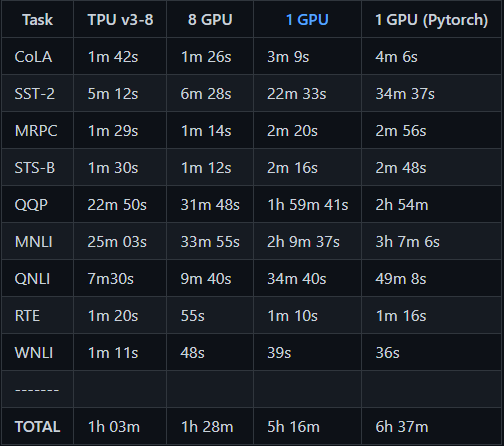

Now that we have a an answer to "why should I learn Flax?" - let's start our descent!

### A toy example - training a linear regression model

In [ ]:
# Set problem dimensions
nsamples = 20
xdim = 10
ydim = 5

# Generate random ground truth W and b
key = random.PRNGKey(0)
k1, k2 = random.split(key)
W = random.normal(k1, (xdim, ydim))
b = random.normal(k2, (ydim,))
true_params = freeze({'params': {'bias': b, 'kernel': W}})

# Generate samples with additional noise
ksample, knoise = random.split(k1)
x_samples = random.normal(ksample, (nsamples, xdim))
y_samples = jnp.dot(x_samples, W) + b 
y_samples += 0.1*random.normal(knoise,(nsamples, ydim)) # Adding noise
print('x shape:', x_samples.shape, '; y shape:', y_samples.shape)

In [ ]:
def make_mse_func(x_batched, y_batched):
  def mse(params):
    # Define the squared loss for a single pair (x,y)
    def squared_error(x, y):
      pred = model.apply(params, x)
      return jnp.inner(y-pred, y-pred)/2.0
    # We vectorize the previous to compute the average of the loss on all samples.
    return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)
  return jax.jit(mse) # And finally we jit the result.

# Get the sampled loss
loss = make_mse_func(x_samples, y_samples)

In [ ]:
alpha = 0.3 # Gradient step size
print('Loss for "true" W,b: ', loss(true_params))
grad_fn = jax.value_and_grad(loss)

for i in range(101):
  # We perform one gradient update
  loss_val, grads = grad_fn(params)
  params = jax.tree_multimap(lambda p, g: p - alpha * g,
                            params, grads)
  if i % 10 == 0:
    print('Loss step {}: '.format(i), loss_val)

Doing the same thing with dedicated optimizers!

Enter DeepMind's optax!

In [ ]:
tx = optax.sgd(learning_rate=alpha)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(loss)

In [ ]:
for i in range(101):
  loss_val, grads = loss_grad_fn(params)
  updates, opt_state = tx.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  if i % 10 == 0:
    print('Loss step {}: '.format(i), loss_val)

# After training you can save/load the model using flax's serialization module 

### Create custom models

In [ ]:
class ExplicitMLP(nn.Module):
  features: Sequence[int]  # data field (Module is Python's dataclass)

  def setup(self):  # because Python dataclass took the __init__ function...
    # we automatically know what to do with lists, dicts of submodules
    self.layers = [nn.Dense(feat) for feat in self.features]
    # for single submodules, we would just write:
    # self.layer1 = nn.Dense(feat1)

  def __call__(self, inputs):
    x = inputs
    for i, lyr in enumerate(self.layers):
      x = lyr(x)
      if i != len(self.layers) - 1:
        x = nn.relu(x)
    return x

key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.uniform(key1, (4,4))

model = ExplicitMLP(features=[3,4,5])
params = model.init(key2, x)
y = model.apply(params, x)

print('initialized parameter shapes:\n', jax.tree_map(jnp.shape, unfreeze(params)))
print('output:\n', y)

# todo: use @nn.compact instead

Going deeper

In [ ]:
class SimpleDense(nn.Module):
  features: int
  kernel_init: Callable = nn.initializers.lecun_normal()
  bias_init: Callable = nn.initializers.zeros

  @nn.compact
  def __call__(self, inputs):
      # We could also declare kernel/bias in setup() fn
    kernel = self.param('kernel',
                        self.kernel_init, # Initialization function, RNG passed implicitly
                        (inputs.shape[-1], self.features))  # shape info.
    y = lax.dot_general(inputs, kernel,
                        (((inputs.ndim - 1,), (0,)), ((), ())),) # TODO Why not jnp.dot?
    bias = self.param('bias', self.bias_init, (self.features,))
    y = y + bias
    return y

key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.uniform(key1, (4,4))

model = SimpleDense(features=3)
params = model.init(key2, x)
y = model.apply(params, x)

print('initialized parameters:\n', params)
print('output:\n', y)


from inspect import signature
print(signature(nn.initializers.lecun_normal()))

Introducing state

In [ ]:
class BiasAdderWithRunningMean(nn.Module):
  decay: float = 0.99

  @nn.compact
  def __call__(self, x):
    # easy pattern to detect if we're initializing via empty variable tree
    is_initialized = self.has_variable('batch_stats', 'mean')
    ra_mean = self.variable('batch_stats', 'mean', lambda s: jnp.zeros(s), x.shape[1:])
    # self.param will by default add this variable to 'params' collection
    # self.variable returns a reference hence .value
    bias = self.param('bias', lambda rng, shape: jnp.zeros(shape), x.shape[1:])
    if is_initialized:
      ra_mean.value = self.decay * ra_mean.value + (1.0 - self.decay) * jnp.mean(x, axis=0, keepdims=True)

    return x - ra_mean.value + bias


key1, key2 = random.split(random.PRNGKey(0), 2)
x = jnp.ones((10,5))
model = BiasAdderWithRunningMean()
variables = model.init(key1, x)
print('initialized variables:\n', variables)
y, updated_state = model.apply(variables, x, mutable=['batch_stats'])
print('updated state:\n', updated_state)

In [ ]:
for val in [1.0, 2.0, 3.0]:
  x = val * jnp.ones((10,5))
  y, updated_state = model.apply(variables, x, mutable=['batch_stats'])
  old_state, params = variables.pop('params')
  variables = freeze({'params': params, **updated_state})
  print('updated state:\n', updated_state) # Shows only the mutable part

Adding the optimizer (maybe delete the above cell)

In [ ]:
def update_step(tx, apply_fn, x, opt_state, params, state):

  def loss(params):
    y, updated_state = apply_fn({'params': params, **state},
                                x, mutable=list(state.keys()))
    l = ((x - y) ** 2).sum()
    return l, updated_state

  (l, state), grads = jax.value_and_grad(loss, has_aux=True)(params)
  updates, opt_state = tx.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return opt_state, params, state

x = jnp.ones((10,5))
variables = model.init(random.PRNGKey(0), x)
state, params = variables.pop('params')
del variables  # Delete variables to avoid wasting resources
tx = optax.sgd(learning_rate=0.02)
opt_state = tx.init(params)

for _ in range(3):
  opt_state, params, state = update_step(tx, model.apply, x, opt_state, params, state)
  print('Updated state: ', state)

# todo: flax.training.train_state.TrainState
# todo: BatchNorm ('batch_stats' collection added) see source code

More comprehensive, contrived example

In [ ]:
class Block(nn.Module):
  features: int
  training: bool
  @nn.compact
  def __call__(self, inputs):
    x = nn.Dense(self.features)(inputs)
    x = nn.Dropout(rate=0.5)(x, deterministic=not self.training)
    x = nn.BatchNorm(use_running_average=not self.training)(x)
    return x

key1, key2, key3, key4 = random.split(random.PRNGKey(0), 4)
x = random.uniform(key1, (3,4,4))

model = Block(features=3, training=True)

init_variables = model.init({'params': key2, 'dropout': key3}, x)
_, init_params = init_variables.pop('params')

# When calling `apply` with mutable kinds, returns a pair of output, 
# mutated_variables.
y, mutated_variables = model.apply(
    init_variables, x, rngs={'dropout': key4}, mutable=['batch_stats'])

# Now we reassemble the full variables from the updates (in a real training
# loop, with the updated params from an optimizer).
updated_variables = freeze(dict(params=init_params, 
                                **mutated_variables))

print('updated variables:\n', updated_variables)
print('initialized variable shapes:\n', 
      jax.tree_map(jnp.shape, init_variables))
print('output:\n', y)

# Let's run these model variables during "evaluation":
eval_model = Block(features=3, training=False)
y = eval_model.apply(updated_variables, x)  # Nothing mutable; single return value.
print('eval output:\n', y)

# check out remat if you have memory expensive computation

In [ ]:
# capture_intermediates
# check out https://flax.readthedocs.io/en/latest/howtos/extracting_intermediates.html
# for more options

# todo: add this to some of the above examples instead
@jax.jit
def init(key, x):
  variables = CNN().init(key, x)
  return variables

@jax.jit
def predict(variables, x):
  y, state = CNN().apply(variables, x, capture_intermediates=True, mutable=["intermediates"])
  intermediates = state['intermediates']
  fin = jax.tree_map(lambda xs: jnp.all(jnp.isfinite(xs)), intermediates)
  return y, fin

variables = init(jax.random.PRNGKey(0), batch)
y, is_finite = predict(variables, batch)
all_finite = all(jax.tree_leaves(is_finite))
assert all_finite, "non finite intermediate detected!"

filter_Dense = lambda mdl, method_name: isinstance(mdl, nn.Dense)
filter_encodings = lambda mdl, method_name: method_name == "encode"

y, state = CNN().apply(variables, batch, capture_intermediates=filter_Dense, mutable=["intermediates"])
dense_intermediates = state['intermediates']

### Full MNIST example

Modified the official MNIST example here: https://github.com/google/flax/tree/main/examples/mnist

In [ ]:
# todo: modification using Dropout, BatchNorm
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    x = nn.log_softmax(x)
    return x

In [ ]:
def cross_entropy_loss(*, logits, labels):
  

def compute_metrics(*, logits, labels):
  loss = cross_entropy_loss(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

In [ ]:
def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[..., 0], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

# todo: add PyTorch dataloading from my previous notebook

In [ ]:
def create_train_state(rng, learning_rate, momentum):
  """Creates initial `TrainState`."""
  cnn = CNN()
  params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.sgd(learning_rate, momentum)
  return train_state.TrainState.create(
      apply_fn=cnn.apply, params=params, tx=tx)

In [ ]:
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = CNN().apply({'params': params}, batch['image'])
    one_hot_labels = jax.nn.one_hot(batch['label'], num_classes=10)
    loss = -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(logits=logits, labels=batch['label'])
  return state, metrics

@jax.jit
def eval_step(params, batch):
  logits = CNN().apply({'params': params}, batch['image'])
  return compute_metrics(logits=logits, labels=batch['label'])

In [ ]:
def train_epoch(state, train_ds, batch_size, epoch, rng):
  """Train for a single epoch."""
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, train_ds_size)
  perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))
  batch_metrics = []
  for perm in perms:
    batch = {k: v[perm, ...] for k, v in train_ds.items()}
    state, metrics = train_step(state, batch)
    batch_metrics.append(metrics)

  # compute mean of metrics across each batch in epoch.
  batch_metrics_np = jax.device_get(batch_metrics)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

  print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
      epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))

  return state

In [ ]:
def eval_model(params, test_ds):
  metrics = eval_step(params, test_ds)
  metrics = jax.device_get(metrics)
  summary = jax.tree_map(lambda x: x.item(), metrics)
  return summary['loss'], summary['accuracy']

In [ ]:

rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

earning_rate = 0.1
momentum = 0.9
num_epochs = 10
batch_size = 32

state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

or epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)
  # Run an optimization step over a training batch
  state = train_epoch(state, train_ds, batch_size, epoch, input_rng)
  # Evaluate on the test set after each training epoch 
  test_loss, test_accuracy = eval_model(state.params, test_ds)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))

In [ ]:
# Find all mistakes in testset.
logits = train.CNN().apply({'params': state.params}, test_ds['image'])
error_idxs, = jnp.where(test_ds['label'] != logits.argmax(axis=1))
len(error_idxs) / len(logits)

In [ ]:
# Show some of them.
show_img_grid(
    [test_ds['image'][idx] for idx in error_idxs[:25]],
    [f'pred={logits[idx].argmax()}' for idx in error_idxs[:25]],
)

### Bonus: walk-through the real parallel ImageNet CNN example

In [ ]:
# jump to https://github.com/google/flax/tree/main/examples/imagenet

HuggingFace examples, community week are a good resource:

1) https://github.com/huggingface/transformers/tree/master/examples/flax

2) https://github.com/huggingface/transformers/tree/master/examples/research_projects/jax-projects

Source code is also your friend, library is still evolving

Show HF's benchmark results (Flax is fast!)